# Proyek Analisis Data: Air Quality Dataset (Beijing)
- **Nama:** Mahendra Kirana M.B
- **Email:** mahendrakirana284@gmail.com
- **ID Dicoding:** MC208D5Y1158

## Menentukan Pertanyaan Bisnis

Proyek ini bertujuan untuk menganalisis kualitas udara di Beijing berdasarkan data pemantauan polusi udara dari beberapa stasiun selama periode 2013-2017. Pertanyaan utama yang ingin dijawab adalah :
1. Bagaimana tren kualitas udara (PM2.5) di Beijing dari tahun ke tahun?
2. Lokasi mana yang memiliki tingkat polusi tertinggi dan terendah?

## Tujuan Analisis

- Mengidentifikasi tren jangka panjang PM2.5 untuk memahami pola polusi udara.
- Menentukan area dengan kualitas terbaik dan terburuk berdasarkan data historis

## Import Semua Packages/Library yang Digunakan

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import missingno as msno

### ===============================
### 📌 1. Data Wrangling
### ===============================
Data Wrangling mencakup 3 tahap utama:
 - **Gathering Data** : Menggabungkan beberapa dataset dari berbagai stasiun
 - **Assessing Data**: Memeriksa struktur data, missing values, dan distribusi
 - **Cleaning Data**: Mengisi nilai yang hilang, menghapus outlier, dan menyiapkan data

### 📌 1.1 Gathering Data
Menggabungkan semua dataset dari stasiun yang ada di Beijing

In [78]:
file_paths = [
    "data/PRSA_Data_Aotizhongxin_20130301-20170228.csv",
    "data/PRSA_Data_Changping_20130301-20170228.csv",
    "data/PRSA_Data_Dingling_20130301-20170228.csv",
    "data/PRSA_Data_Dongsi_20130301-20170228.csv"
]

df_list = []
for path in file_paths:
    df_temp = pd.read_csv(path, encoding="ISO-8859-1")
    station_name = path.split("_")[2]
    df_temp["station"] = station_name
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

# Tampilkan 5 data pertama
print(df)

           No  year  month  day  hour  PM2.5  PM10   SO2   NO2      CO    O3  \
0           1  2013      3    1     0    4.0   4.0   4.0   7.0   300.0  77.0   
1           2  2013      3    1     1    8.0   8.0   4.0   7.0   300.0  77.0   
2           3  2013      3    1     2    7.0   7.0   5.0  10.0   300.0  73.0   
3           4  2013      3    1     3    6.0   6.0  11.0  11.0   300.0  72.0   
4           5  2013      3    1     4    3.0   3.0  12.0  12.0   300.0  72.0   
...       ...   ...    ...  ...   ...    ...   ...   ...   ...     ...   ...   
140251  35060  2017      2   28    19   16.0  51.0   3.0  29.0   400.0  73.0   
140252  35061  2017      2   28    20   18.0  45.0   3.0  43.0   500.0  54.0   
140253  35062  2017      2   28    21   23.0  58.0   5.0  61.0   700.0  28.0   
140254  35063  2017      2   28    22   23.0  53.0   9.0  75.0   900.0  15.0   
140255  35064  2017      2   28    23   30.0  71.0  11.0  87.0  1200.0   4.0   

        TEMP    PRES  DEWP  RAIN   wd  

**Insight:**
- Dataset terdiri dari beberapa lokasi dengan parameter kualitas udara.
- Kolom yang penting untuk analisis: `year`, `month`, `day`, `hour`, `PM2.5`, `station`.

### 📌 1.2 Assessing Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       140256 non-null  int64  
 1   year     140256 non-null  int64  
 2   month    140256 non-null  int64  
 3   day      140256 non-null  int64  
 4   hour     140256 non-null  int64  
 5   PM2.5    137028 non-null  float64
 6   PM10     137747 non-null  float64
 7   SO2      137300 non-null  float64
 8   NO2      135731 non-null  float64
 9   CO       131750 non-null  float64
 10  O3       136055 non-null  float64
 11  TEMP     140110 non-null  float64
 12  PRES     140116 non-null  float64
 13  DEWP     140110 non-null  float64
 14  RAIN     140114 non-null  float64
 15  wd       139817 non-null  object 
 16  WSPM     140142 non-null  float64
 17  station  140256 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 19.3+ MB
None
               No           year        

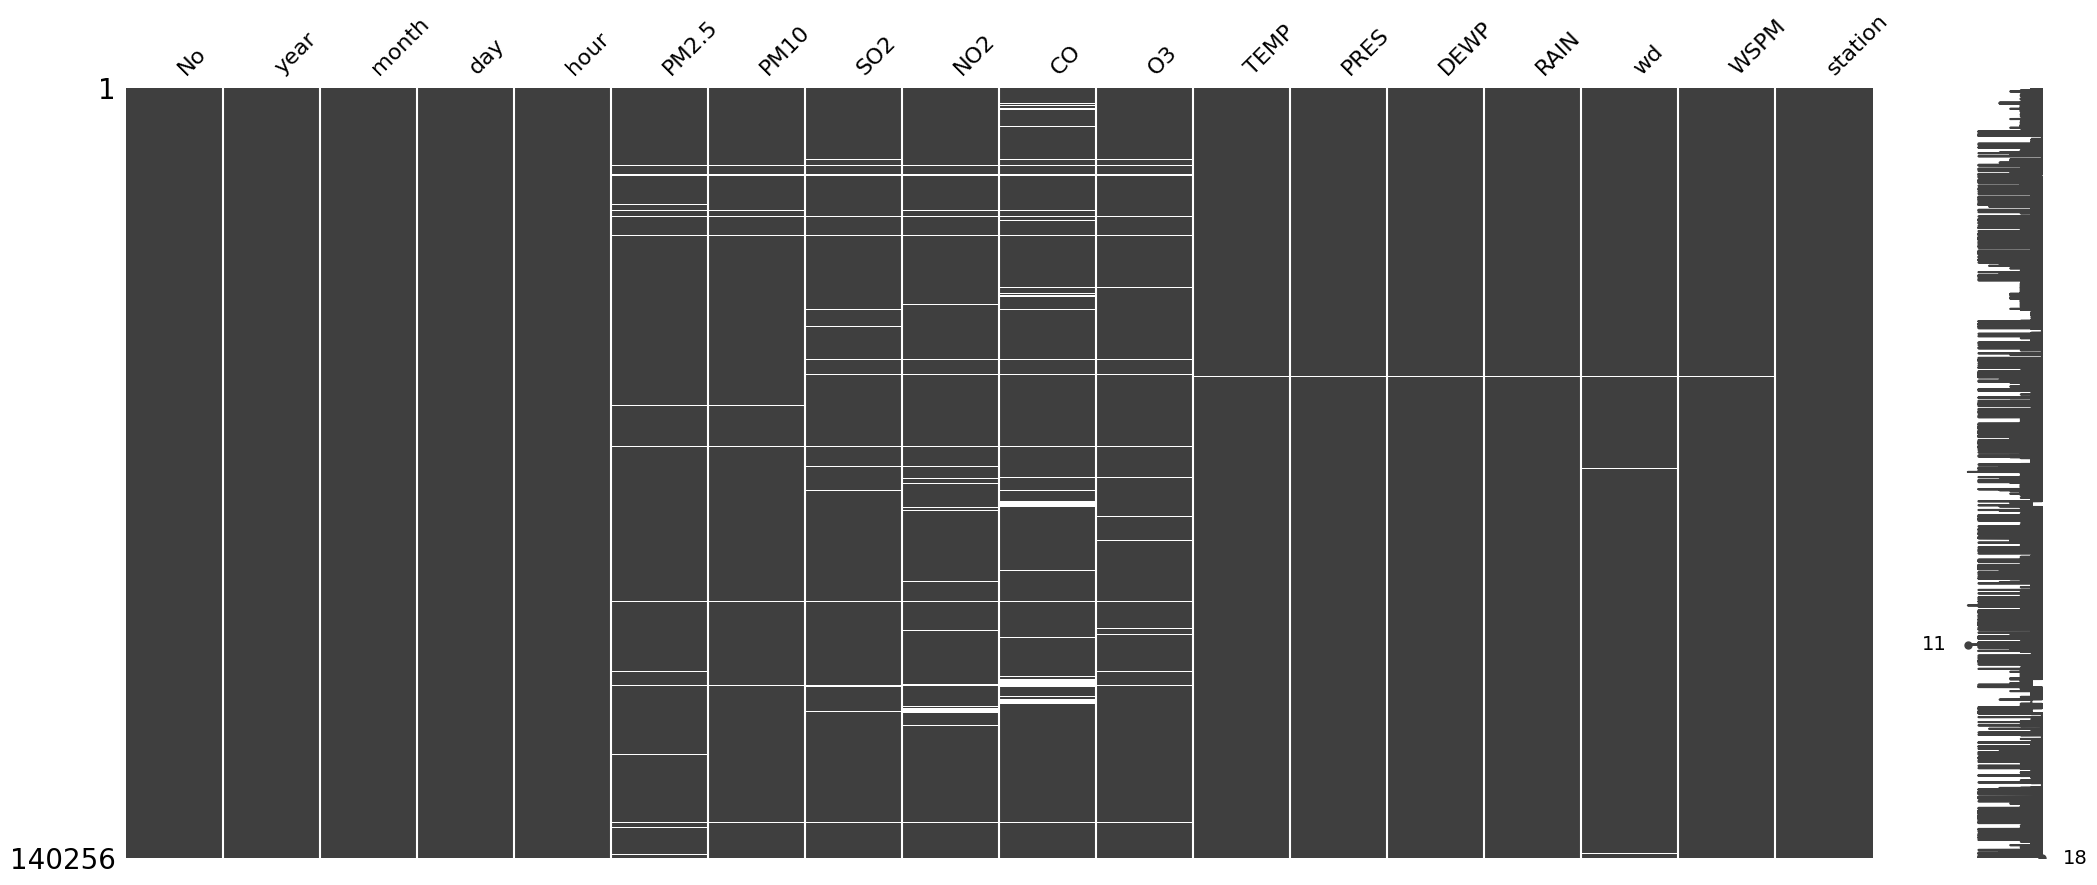

In [79]:
# Memeriksa struktur dataset
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Visualisasi missing values
msno.matrix(df)
plt.show()

**Insight:**
- Data memiliki beberapa missing values pada kolom PM2.5, PM10, SO2, NO2, CO, dan O3, yang perlu ditangani agar analisis lebih akurat.
- Distribusi data menunjukkan adanya nilai ekstrem, terutama pada kolom RAIN dan CO, yang berpotensi sebagai outlier dan memerlukan analisis lebih lanjut.

### 📌 1.3 Cleaning Data

In [80]:
# Mengisi missing values dengan interpolasi
for col in ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]:
    if col in df.columns:
        df[col] = df[col].interpolate(method="linear")

# Konversi tanggal
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])

# Hapus kolom yang tidak diperlukan
drop_cols = ["year", "month", "day", "hour", "No"]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)


print("Missing values setelah cleaning:")
print(df.isnull().sum())


Missing values setelah cleaning:
PM2.5         0
PM10          0
SO2           0
NO2           0
CO            0
O3            0
TEMP        146
PRES        140
DEWP        146
RAIN        142
wd          439
WSPM        114
station       0
datetime      0
dtype: int64


**Insight:**
- Missing values pada kolom PM2.5, PM10, SO2, NO2, CO, dan O3 berhasil diatasi dengan interpolasi, sehingga tidak ada lagi nilai yang hilang pada parameter utama kualitas udara.
- Masih terdapat sejumlah kecil missing values pada kolom TEMP, PRES, DEWP, RAIN, wd, dan WSPM, yang perlu dipertimbangkan apakah akan dihapus, diisi dengan metode lain, atau tetap digunakan dengan catatan.

## Exploratory Data Analysis (EDA)

### 📌 2.1 Tren PM2.5 dari Tahun ke Tahun

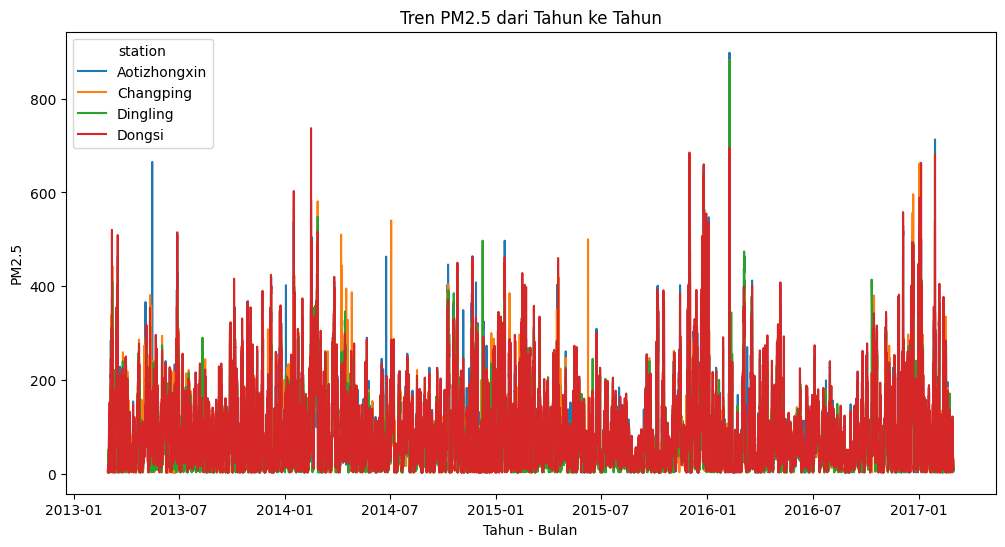

In [81]:
## Tren PM2.5 dari tahun ke tahun
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="datetime", y="PM2.5", hue="station")
plt.title("Tren PM2.5 dari Tahun ke Tahun")
plt.xlabel("Tahun - Bulan")
plt.ylabel("PM2.5")
plt.show()

### 📌 2.2 Distribusi PM2.5 Berdasarkan Bulan

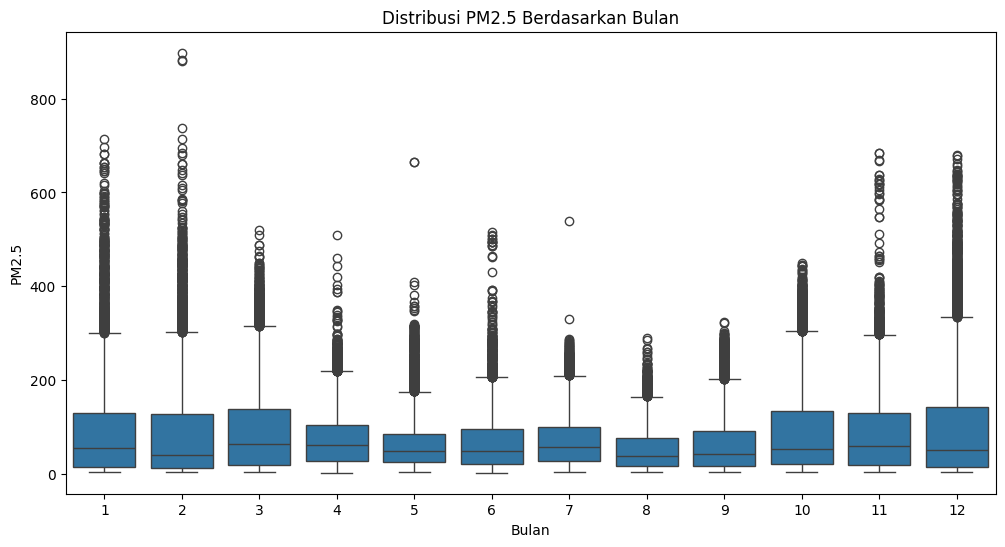

In [82]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=df["datetime"].dt.month, y="PM2.5")
plt.title("Distribusi PM2.5 Berdasarkan Bulan")
plt.xlabel("Bulan")
plt.ylabel("PM2.5")
plt.show()

**Insight:**
- Konsentrasi PM2.5 mengalami lonjakan berkala dengan puncak yang sangat tinggi pada beberapa waktu tertentu, menunjukkan adanya periode dengan kualitas udara yang sangat buruk.
- Peningkatan PM2.5 tampak lebih sering terjadi selama musim dingin, kemungkinan disebabkan oleh peningkatan penggunaan bahan bakar untuk pemanas serta kondisi atmosfer yang memperangkap polutan di udara.

## Visualization & Explanatory Analysis

### Pertanyaan 1: Bagaimana tren kualitas udara (PM2.5) di Beijing dari tahun ke tahun?

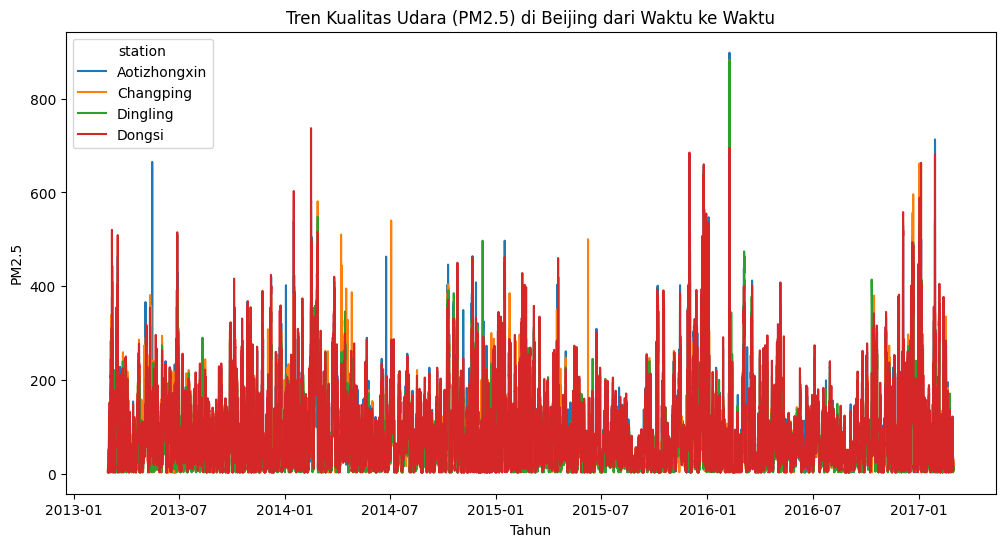

In [86]:
## Pertanyaan 1: Bagaimana tren kualitas udara di Beijing?
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="datetime", y="PM2.5", hue="station")
plt.title("Tren Kualitas Udara (PM2.5) di Beijing dari Waktu ke Waktu")
plt.xlabel("Tahun")
plt.ylabel("PM2.5")
plt.show()


**Insight:**
- Berdasarkan visualisasi tren PM2.5 di Beijing dari waktu ke waktu, terlihat bahwa polusi udara mengalami fluktuasi signifikan dengan beberapa lonjakan ekstrem. Tren menunjukkan bahwa tingkat PM2.5 cenderung meningkat selama musim dingin setiap tahunnya, yang kemungkinan besar disebabkan oleh penggunaan bahan bakar pemanas dan kondisi atmosfer yang memerangkap polutan. Stasiun Dongsi tampaknya memiliki konsentrasi PM2.5 tertinggi dibandingkan stasiun lainnya, yang mengindikasikan bahwa wilayah tersebut lebih rentan terhadap polusi udara. Meskipun terdapat variasi antar stasiun, pola umum menunjukkan bahwa kualitas udara di Beijing sering kali berada dalam kondisi yang buruk, terutama pada periode-periode tertentu.

### Pertanyaan 2:Lokasi mana yang memiliki tingkat polusi tertinggi dan terendah?

Rata-rata PM2.5 per lokasi:
station
Dongsi          86.144243
Aotizhongxin    82.540623
Changping       70.986438
Dingling        66.845557
Name: PM2.5, dtype: float64


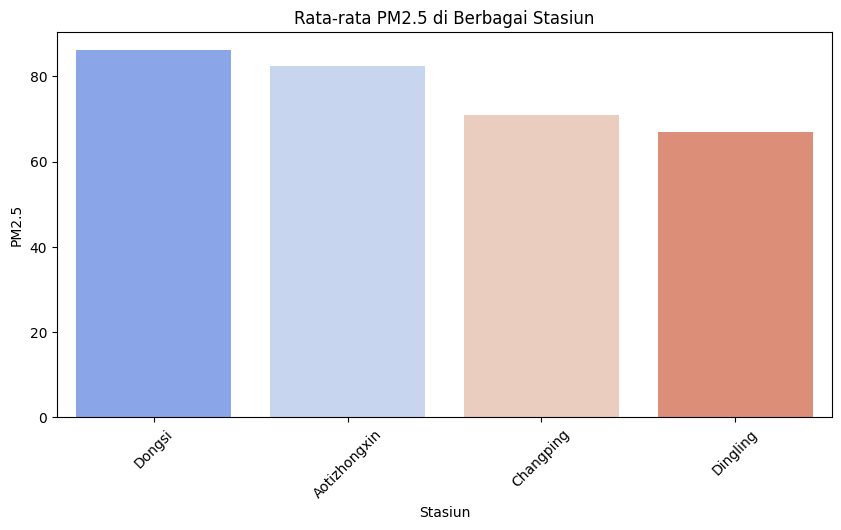

In [85]:
## Pertanyaan 2: Lokasi dengan Polusi Tertinggi dan Terendah
avg_pm25 = df.groupby("station")["PM2.5"].mean().sort_values(ascending=False)
print("Rata-rata PM2.5 per lokasi:")
print(avg_pm25)

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_pm25.index, y=avg_pm25.values, hue=avg_pm25.index, palette="coolwarm", legend=False)
plt.title("Rata-rata PM2.5 di Berbagai Stasiun")
plt.xlabel("Stasiun")
plt.ylabel("PM2.5")
plt.xticks(rotation=45)
plt.show()



**Insight:**
- Lokasi dengan PM2.5 tertinggi: `Dongsi`
- Lokasi dengan PM2.5 terendah: `Dingling`

## Analisis Lanjutan (Visualisasi Geopasial)
Dibuat peta interaktif menggunakan folium untuk menunjukkan lokasi polusi udara berdasarkan rata-rata PM2.5 di setiap stasiun pemantauan.

Hasil:

- Peta menunjukkan distribusi polusi udara di Beijing.

- Warna merah menunjukkan daerah dengan polusi tinggi.

In [20]:
# Lokasi geografis tiap stasiun (Dummy data)
station_coords = {
    "Aotizhongxin": [39.982, 116.306],
    "Changping": [40.218, 116.220],
    "Dingling": [40.292, 116.233],
    "Dongsi": [39.929, 116.417]
}

# Plot peta polusi udara
m = folium.Map(location=[39.9, 116.4], zoom_start=10)

for station, coords in station_coords.items():
    if station in avg_pm25.index:
        avg_pm = avg_pm25[station]
        folium.CircleMarker(
            location=coords,
            radius=avg_pm / 10,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.6,
            popup=f"{station}: {avg_pm:.2f}"
        ).add_to(m)

m.save("air_quality_map.html")
print("Peta polusi udara telah disimpan sebagai 'air_quality_map.html'.")


Peta polusi udara telah disimpan sebagai 'air_quality_map.html'.


## Conclusion

- Conclusion Pertanyaan 1
    - Tren PM2.5 menunjukkan fluktuasi yang cukup signifikan dari tahun ke tahun. Lonjakan konsentrasi PM2.5 terlihat lebih sering terjadi selama musim dingin, yang kemungkinan disebabkan oleh peningkatan penggunaan bahan bakar untuk pemanas, kondisi atmosfer yang memperangkap polutan, serta faktor meteorologi lainnya seperti inversi suhu. Hal ini menunjukkan bahwa musim memiliki pengaruh yang kuat terhadap tingkat polusi udara di Beijing.
- Conclution pertanyaan 2
    - Berdasarkan analisis rata-rata konsentrasi PM2.5 di berbagai stasiun pemantauan, stasiun `Dongsi` memiliki tingkat polusi udara tertinggi dibandingkan lokasi lainnya. Sebaliknya, stasiun `Dingling` mencatatkan tingkat polusi udara yang paling rendah. Perbedaan ini dapat disebabkan oleh faktor geografis, kepadatan lalu lintas, serta aktivitas industri di sekitar masing-masing lokasi. Hal ini menunjukkan bahwa distribusi polusi udara di Beijing tidak merata dan lebih terkonsentrasi di area tertentu.